## Домашнее задание 7. Урок 7. Классификация с помощью KNN. Кластеризация K-means

#### Задание 1.

К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от номера соседа.

#### Задание 2. 

К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от расстояния до соседа. Сравнить метрики качества и сложность разделяющей гиперплоскости. Сделать выводы.

#### Задание 3. 
Настроить оптимальное значение числа соседей для моделей из п.1 и п.2, сделать выводы. 

#### Задание4 (опция). 

Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

## KNN

#### Задания 1-3

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

Загрузим датасет:

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

Визуализируем его:

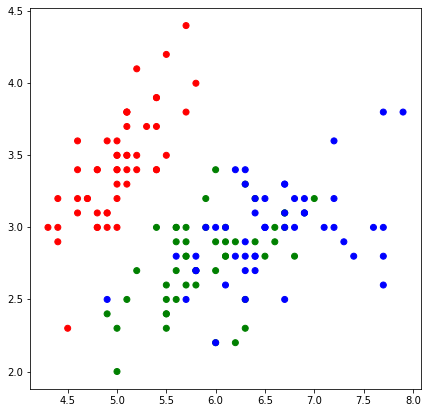

In [4]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)
plt.show()

Инициализируем клас KNN для метода ближайших соседей. Сразу предусмотрим добавление весов в зависимости от номера соседа или от расстояния до него. Параметр weights определяет, будем использовать веса или нет, параметр calc_weights_by определяет методику расчета весов - при 'number' рассчитываем по номеру соседа, при 'distance' рассчитываем по расстоянию до соседа. Расчет будем производить по формулам: $w(i) = q^{i}$,   $q \in (0,1)$ и $w(d) = q^{d}$,   $q \in (0,1)$. q, соответственно, определяет параметр для расчета весов.

In [5]:
class KNN:
    
    def __init__(self, k=3, weights=False, calc_weights_by='number', q=.5):
        self.k = k
        self.weights = weights
        self.calc_weights_by = calc_weights_by
        self.q = q
        self.X = None
        self.y = None
    
    def e_metrics(self, x1, x2):

        return np.linalg.norm(x1 - x2)
    
    def get_classes(self, test_distances):
        classes = {class_item: 0 for class_item in set(self.y)}
        neightbours = sorted(test_distances)[0:self.k]
        
        if self.weights:
            if self.calc_weights_by == 'number':
                for idx in range(len(neightbours)):
                    classes[neightbours[idx][1]] += self.q**idx # Добавление весов в зависимости от номера соседа
            elif self.calc_weights_by == 'distance':
                for itm in neightbours:
                    classes[itm[1]] += self.q**itm[0] # Добавление весов в зависимости от расстояния до соседа
        else:
            for itm in neightbours:
                classes[itm[1]] += 1 # Реализация без весов
        
        return classes
                
    
    def fit(self, X, y):
        self.X, self.y = X, y
    
    def predict(self, x_test):
        answers = []
        for x in x_test:
            test_distances = []

            for i in range(len(self.X)):

                # расчет расстояния от классифицируемого объекта до
                # объекта обучающей выборки
                distance = self.e_metrics(x, self.X[i])

                # Записываем в список значение расстояния и ответа на объекте обучающей выборки
                test_distances.append((distance, self.y[i]))
            
            classes = self.get_classes(test_distances)


            # Записываем в список ответов наиболее часто встречающийся класс
            answers.append(sorted(classes, key=classes.get)[-1])
        return answers        

Инициализируем функцию расчета Accuracy:

In [6]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Инициализируем функцию построения графика accuracy для трейна и теста в зависимости от количества ближайших соседей:

In [7]:
def evaluate_preds(X_train, y_train, y_test, k_list, calc_weights_by, q, weights=True):
    train_accuracy = []
    test_accuracy = []
    for k in k_list:
        knn = KNN(k=k, weights=weights, calc_weights_by=calc_weights_by, q=q)
        knn.fit(X_train, y_train)
        y_train_pred = knn.predict(X_train)
        y_test_pred = knn.predict(X_test)
        train_accuracy.append(accuracy(y_train_pred, y_train))
        test_accuracy.append(accuracy(y_test_pred, y_test))
    plt.figure(figsize = (16, 7))
    plt.plot(k_list, train_accuracy, label='train')
    plt.plot(k_list, test_accuracy, label='test')
    plt.title(f'KNN, calc weights by {calc_weights_by}, q = {q}')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

Построим график для весов, расчитанных по номеру соседа, с q=0.5:

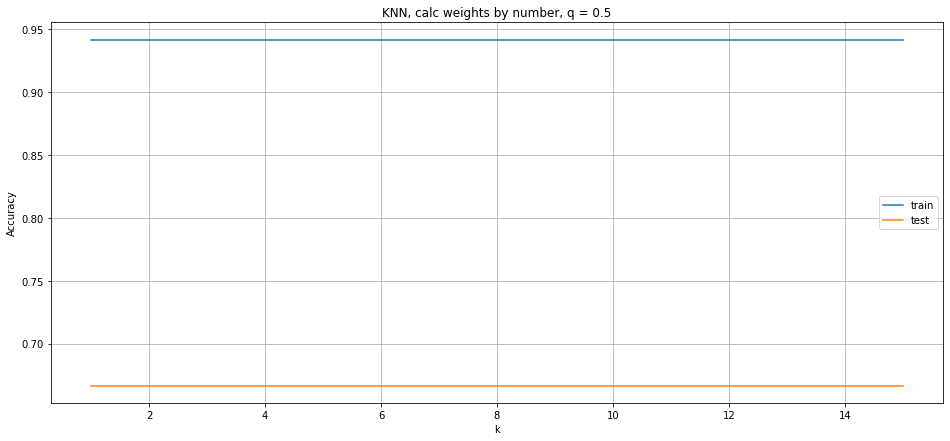

In [8]:
k_list = np.arange(1, 16)
evaluate_preds(X_train, y_train, y_test, k_list, 'number', 0.5)

Как видно по графику, качество модели не улучшается при увеличении количества ближайших соседей. Значит, значение q=0.5 слишком маленькое, и остальным соседям не удается перевесить самого ближайшего соседа. Увеличим q:

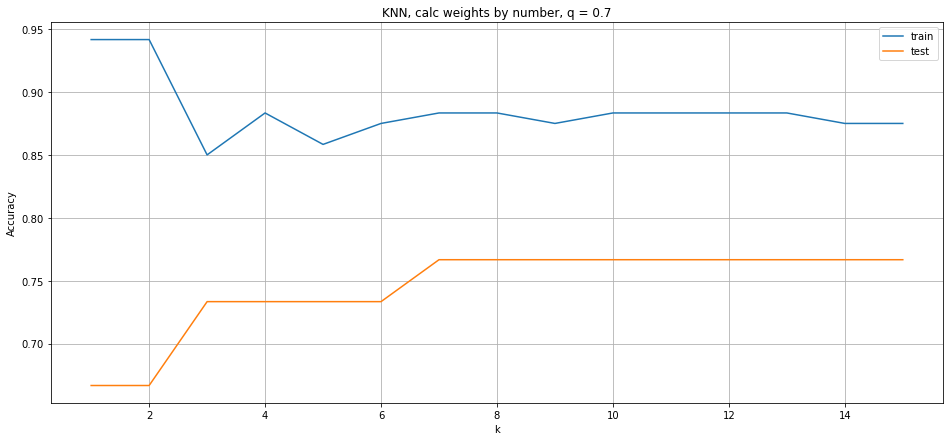

In [9]:
evaluate_preds(X_train, y_train, y_test, k_list, 'number', 0.7)

Качество увеличилось, но модель не дообучается, разница метрики на трейне и тесте велика. Увеличим q до 0.8:

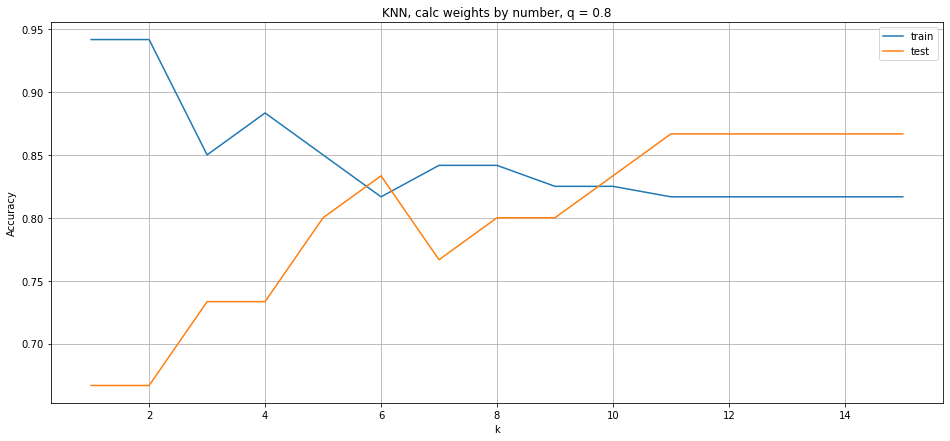

In [10]:
evaluate_preds(X_train, y_train, y_test, k_list, 'number', 0.8)

Теперь метрики трейна и теста сходятся, и даже метрика теста превышает трейн. Причем начиная с k=11 модель ведет себя стабильно, значения метрики больше не скачут.

Сравним поведение этой модели с весами с моделью без весов. Можно просто поставить q=1:

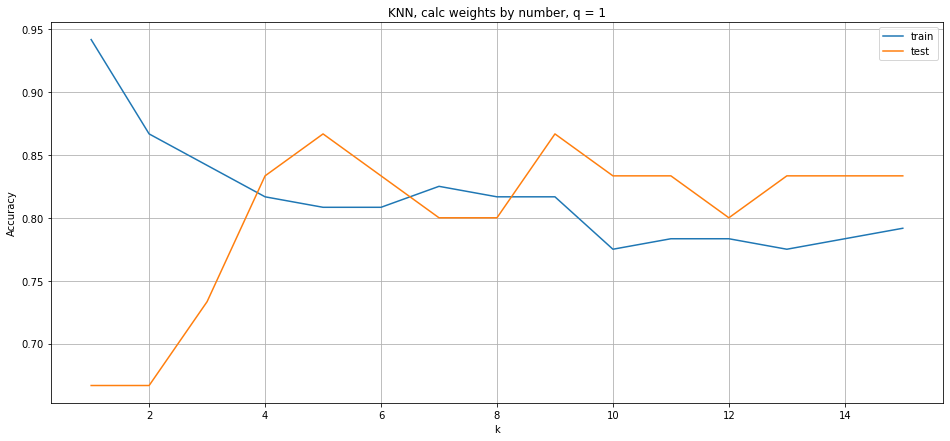

In [11]:
evaluate_preds(X_train, y_train, y_test, k_list, 'number', 1)

Видно, что алгоритм без весов сходится на более низкой метрике. А при тех k, при которых метрика самая высокая, алгоритм работает нестабильно. То есть в окрестностях этих точек метрика резко меняется, значит при другом наборе тестовой выборки значение метрики в этих точках может быть совсем другим. Таким образом, алгоритм с весами выглядит более надежным.

Построим график метрики от количества соседей при расчете весов по расстоянию и с q=0.5:

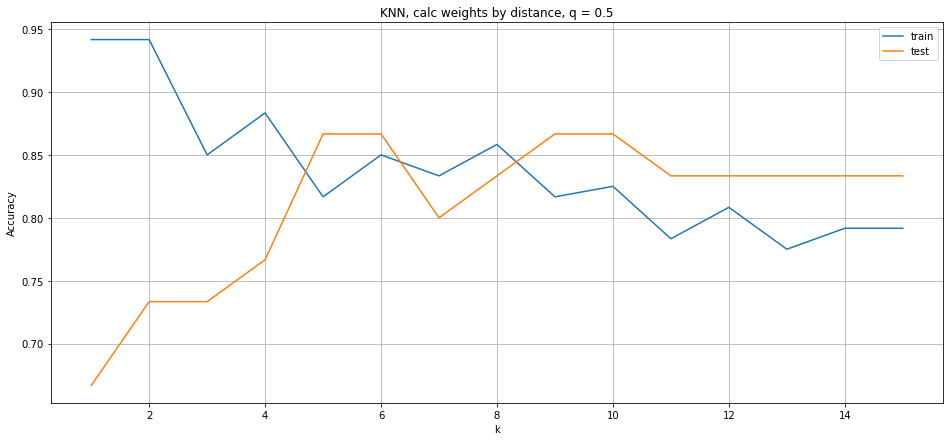

In [12]:
evaluate_preds(X_train, y_train, y_test, k_list, 'distance', 0.5)

Видно, что при q=0.5 кривые почти не отличаются от кривых без весов. Попробуем уменьшить q:

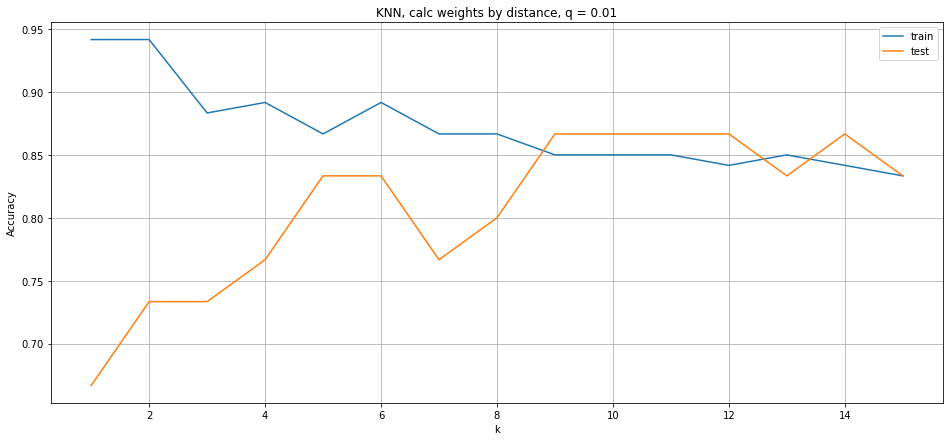

In [13]:
evaluate_preds(X_train, y_train, y_test, k_list, 'distance', 0.01)

Удалось подобрать q=0.01, при котором алгоритм имеет высокую метрику и выглядит достаточно надежным. При расчете весов по расстоянию метрики на трейне и тесте сходятся более плавно, в отличие от расчета весов по номеру соседа. Но при высоких значениях k метрика все равно может немного скакать, при весах по номеру же при высоких k метрика уже не менялась.

Визуализируем для каждого метода расчета весов, и для модели без весов, разделяющие плоскости при лучших параметрах k и q:

In [14]:
def get_graph(X_train, y_train, k, calc_weights_by, q, weights=True):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    knn = KNN(k=k, calc_weights_by=calc_weights_by, q=q, weights=weights)
    knn.fit(X_train, y_train)
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

Модель без весов:

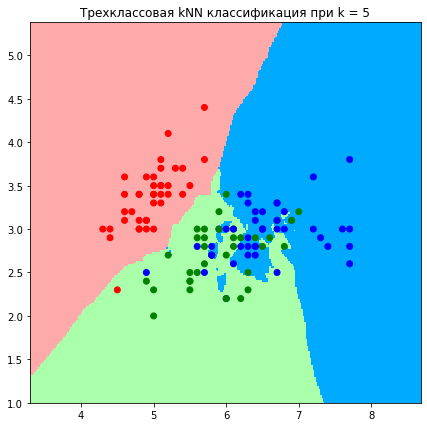

In [15]:
get_graph(X_train, y_train, 5, 'number', 1)

Модель с весами, расчитанными по номеру соседа:

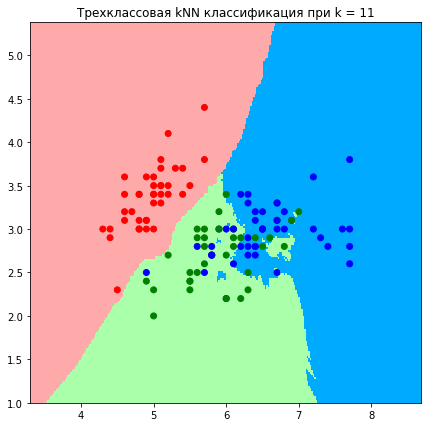

In [16]:
get_graph(X_train, y_train, 11, 'number', .8)

Модель с весами, рассчитанными по расстоянию до соседа:

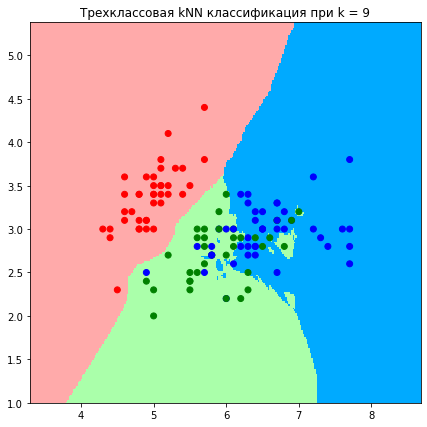

In [17]:
get_graph(X_train, y_train, 9, 'distance', .01)

Итак, все три модели имеют одинаковую метрику качества. Но модели с весами имеют меньше артефактов, а контуры разделяющих плоскостей более плавные. Отличия моделей с весами по номеру соседа и по расстоянию до соседа:

- В модели с весами, рассчитанными по номеру соседа, метрика качества стабилизируется при количестве соседей k=11 и больше не меняется.

- У модели с весами, рассчитанными по расттояниу до соседа, при высоком количестве соседей метрика качества немного скачет, но при малом количестве соседей изменяется более плавно.

В целом, использование весов, рассчитанных обоими способами, дает достаточно хорошую надежную модель с плавными разделяющими плоскостями и малыми вкраплениями артефактов.

## K-means

#### Задание 4.

Сгеннерируем облака точек:

In [18]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=100, random_state=1)

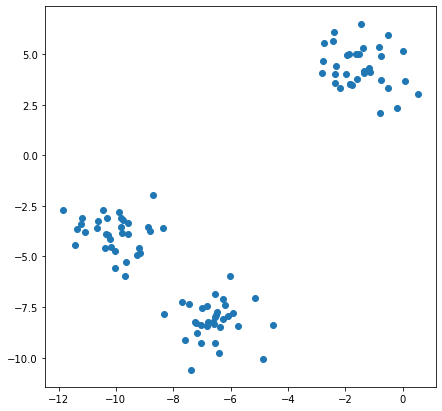

In [19]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [23]:
def e_metrics(x1, x2):
      
    return np.linalg.norm(x1-x2)

Инициализируем функцию кластеризации:

In [24]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

Инициализируем функцию расчета среднего квадратичного внутрикластерного расстояния:

In [25]:
def calc_mean_square_intercluster_distance(centroids, classes):
    centroids = np.array(centroids)
    distance = 0
    for classification in classes:
        objects = np.array(classes[classification])
        distance += sum(map(lambda x: np.sum(x**2), objects - centroids[classification])) / len(objects)
    return distance

Отрисуем график изменения метрики кластеризации при изменении количества кластеров от 1 до 10:

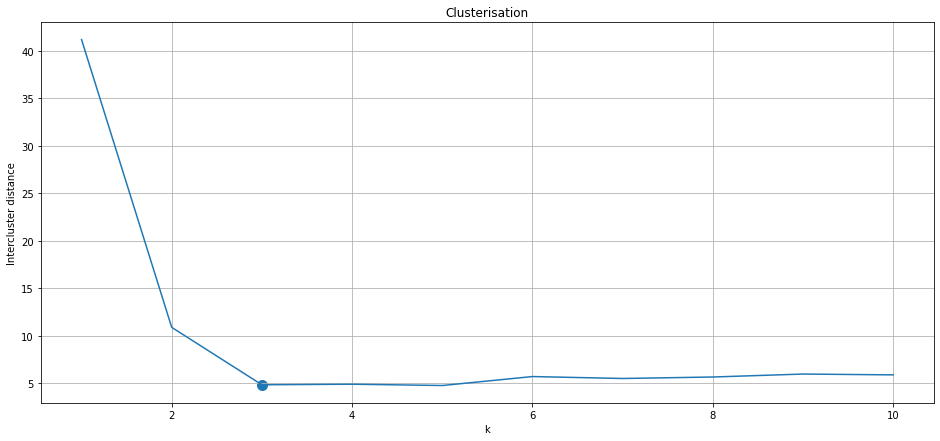

In [26]:
k_list = np.arange(1, 11)
intercluster_distances = []
for k in k_list:
    centroids, clusters = kmeans(X, k, 100, 1e-4)
    intercluster_distances.append(calc_mean_square_intercluster_distance(centroids, clusters))
plt.figure(figsize = (16, 7))
plt.plot(k_list, intercluster_distances)
plt.scatter(3, intercluster_distances[2], marker='o', s=100)
plt.title(f'Clusterisation')
plt.xlabel('k')
plt.ylabel('Intercluster distance')
plt.grid()
plt.show()

Как видно, резкое изменение графика происходит при количестве кластеров, равным трем, что и соответствует действительности. Таким образом, "правило локтя" работает для этого искусственного набора точек.